In [1]:
import pandas as pd
import numpy as np

# 加载数据
user_data = pd.read_csv('/Users/liangyingtong/Desktop/jd/MSOM JD Challenge Data/JD_user_data.csv')
order_data = pd.read_csv('/Users/liangyingtong/Desktop/jd/MSOM JD Challenge Data/JD_order_data.csv')
delivery_data = pd.read_csv('/Users/liangyingtong/Desktop/jd/MSOM JD Challenge Data/JD_delivery_data.csv')

# 1. 筛选3P订单和PLUS会员
orders_3p = order_data[order_data['type'] == 2].copy()  # 3P订单
print(f"3P订单数量: {orders_3p.shape[0]}")
plus_users = user_data[user_data['plus'] == 1]['user_ID'].unique()
orders_3p_plus = orders_3p[orders_3p['user_ID'].isin(plus_users)].copy()
print(f"PLUS会员的3P订单数量: {orders_3p_plus.shape[0]}")
jd_orders = delivery_data['order_ID'].unique()
orders_3p_plus['is_jd_logistics'] = orders_3p_plus['order_ID'].isin(jd_orders)

merged_data = pd.merge(
    orders_3p_plus,
    user_data,
    on='user_ID',
    how='left'
)   

merged_data = pd.merge(
    merged_data,
    delivery_data,
    on='order_ID',
    how='left'
)

3P订单数量: 274521
PLUS会员的3P订单数量: 30142


In [2]:
merged_data['ship_out_time'] = pd.to_datetime(merged_data['ship_out_time'])
merged_data['arr_station_time'] = pd.to_datetime(merged_data['arr_station_time'])
merged_data['arr_time'] = pd.to_datetime(merged_data['arr_time'])

In [3]:
# 改进的时间处理函数
def clean_time(time_str):
    if pd.isna(time_str):
        return pd.NaT
    
    # 处理日期时间格式
    if isinstance(time_str, str):
        # 处理"2018/3/1 08:00"这样的格式
        if ' ' in time_str:
            try:
                return pd.to_datetime(time_str, format='%Y/%m/%d %H:%M')
            except:
                pass
        
        # 处理只有日期的格式
        try:
            return pd.to_datetime(time_str, format='%Y/%m/%d')
        except:
            pass
    
    return pd.NaT

# 处理订单日期和时间
def clean_order_time(date_str, time_str):
    try:
        # 处理日期
        date_part = pd.to_datetime(date_str, format='%Y/%m/%d')
        
        # 处理时间 - 处理异常格式如"50:41.0"
        if isinstance(time_str, str):
            time_parts = time_str.split(':')
            if len(time_parts) == 2:
                hours = min(int(time_parts[0]), 23)  # 限制小时不超过23
                minutes = min(int(float(time_parts[1])), 59)  # 限制分钟不超过59
                time_part = pd.Timedelta(hours=hours, minutes=minutes)
                return date_part + time_part
        
        return date_part  # 如果时间无效，只返回日期部分
    except:
        return pd.NaT


# 处理order_datetime - 使用改进的方法
# 直接解析 order_time 字段
merged_data['order_datetime'] = pd.to_datetime(merged_data['order_time'], errors='coerce')


# 1. 总配送时长（小时）
valid_total_time_mask = merged_data['arr_time'].notnull() & merged_data['order_datetime'].notnull()
merged_data['total_delivery_time'] = pd.Series(np.nan, index=merged_data.index)
merged_data.loc[valid_total_time_mask, 'total_delivery_time'] = (
    merged_data.loc[valid_total_time_mask, 'arr_time'] - 
    merged_data.loc[valid_total_time_mask, 'order_datetime']
).dt.total_seconds() / 3600

# 处理承诺时间（将非数值转换为NaN）
merged_data['promise'] = pd.to_numeric(merged_data['promise'], errors='coerce')
#统一转化成小时
merged_data['promise'] = merged_data['promise'] * 24
# 2. 承诺准时率
valid_promise_mask = merged_data['promise'].notnull() & merged_data['total_delivery_time'].notnull()
merged_data['is_on_time'] = pd.Series(False, index=merged_data.index)
merged_data.loc[valid_promise_mask, 'is_on_time'] = (
    merged_data.loc[valid_promise_mask, 'total_delivery_time'] <= 
    merged_data.loc[valid_promise_mask, 'promise']
)

on_time_rate = (
    merged_data.loc[valid_promise_mask, 'is_on_time'].sum() / 
    valid_promise_mask.sum() * 100
)

# 3. 关键节点耗时
# 仓库到配送站时长（干线运输效率）
valid_station_time_mask = merged_data['arr_station_time'].notnull() & merged_data['ship_out_time'].notnull()
merged_data['station_transit_time'] = pd.Series(np.nan, index=merged_data.index)
merged_data.loc[valid_station_time_mask, 'station_transit_time'] = (
    merged_data.loc[valid_station_time_mask, 'arr_station_time'] - 
    merged_data.loc[valid_station_time_mask, 'ship_out_time']
).dt.total_seconds() / 3600

# 配送站到客户时长（最后一公里效率）
valid_last_mile_mask = merged_data['arr_time'].notnull() & merged_data['arr_station_time'].notnull()
merged_data['last_mile_time'] = pd.Series(np.nan, index=merged_data.index)
merged_data.loc[valid_last_mile_mask, 'last_mile_time'] = (
    merged_data.loc[valid_last_mile_mask, 'arr_time'] - 
    merged_data.loc[valid_last_mile_mask, 'arr_station_time']
).dt.total_seconds() / 3600

In [4]:
merged_data.head()

,order_ID,user_ID,sku_ID,order_date,order_time,quantity,type_x,promise,original_unit_price,final_unit_price,...,package_ID,type_y,ship_out_time,arr_station_time,arr_time,order_datetime,total_delivery_time,is_on_time,station_transit_time,last_mile_time
0,37327053be,e278593de1,90a8e42962,2018-03-01,2018-03-01 18:32:38.0,1,2,NaN,238.0,94.0,...,NaN,NaN,NaT,NaT,NaT,2018-03-01 18:32:38,NaN,False,NaN,NaN
1,c050a87426,f83141d477,159aae0d4c,2018-03-01,2018-03-01 18:12:55.0,1,2,120.0,288.0,160.0,...,08c65f715f,0.0,2018-03-02 14:00:00,2018-03-05 09:00:00,2018-03-05 14:00:00,2018-03-01 18:12:55,91.784722,True,67.0,5.0
2,99c10521db,0012876bfc,04953d3191,2018-03-01,2018-03-01 18:14:51.0,1,2,144.0,0.0,0.0,...,a2094789fb,0.0,2018-03-02 14:00:00,2018-03-06 09:00:00,2018-03-06 18:00:00,2018-03-01 18:14:51,119.752500,True,91.0,9.0
3,7b1fdf8d1c,d497549d1f,da6dcd0f92,2018-03-01,2018-03-01 13:20:53.0,1,2,NaN,188.0,148.0,...,NaN,NaN,NaT,NaT,NaT,2018-03-01 13:20:53,NaN,False,NaN,NaN
4,3a31b98474,905ba74362,a929b13ba3,2018-03-01,2018-03-01 15:06:24.0,4,2,72.0,69.0,31.8,...,c7ac0e2e7f,0.0,2018-03-01 20:00:00,2018-03-04 15:00:00,2018-03-04 17:00:00,2018-03-01 15:06:24,73.893333,False,67.0,2.0


In [5]:
print("\n时效指标统计：")
print(f"平均总配送时长: {merged_data['total_delivery_time'].mean():.2f}小时")
print(f"平均干线运输时长: {merged_data['station_transit_time'].mean():.2f}小时")
print(f"平均最后一公里时长: {merged_data['last_mile_time'].mean():.2f}小时")


时效指标统计：
平均总配送时长: 57.23小时
平均干线运输时长: 42.78小时
平均最后一公里时长: 6.60小时


In [6]:
# 分布对比和假设检验分析
print("\n=== 分布对比和假设检验分析 ===")

# 1. 准时率对比
jd_on_time_rate = merged_data[merged_data['is_jd_logistics'] == True]['is_on_time'].mean() * 100
third_party_on_time_rate = merged_data[merged_data['is_jd_logistics'] == False]['is_on_time'].mean() * 100

print(f"\n准时率对比：")
print(f"JD物流准时率: {jd_on_time_rate:.2f}%")
print(f"第三方物流准时率: {third_party_on_time_rate:.2f}%")
print(f"准时率差异: {jd_on_time_rate - third_party_on_time_rate:.2f}%")


=== 分布对比和假设检验分析 ===

准时率对比：
JD物流准时率: 85.84%
第三方物流准时率: 0.00%
准时率差异: 85.84%


In [7]:
# 1. 基础统计分析
print("\n=== 基础统计分析 ===")
print(f"PLUS会员的3P订单总数: {len(merged_data):,}")
print(f"使用京东物流的3P订单数: {len(merged_data[merged_data['is_jd_logistics']]):,}")
print(f"使用第三方物流的3P订单数: {len(merged_data[~merged_data['is_jd_logistics']]):,}")


=== 基础统计分析 ===
PLUS会员的3P订单总数: 30,147
使用京东物流的3P订单数: 6,778
使用第三方物流的3P订单数: 23,369


In [8]:
print(merged_data['is_jd_logistics'].value_counts(normalize=True))

is_jd_logistics
False    0.775168
True     0.224832
Name: proportion, dtype: float64


In [9]:
from scipy.stats import ttest_ind

# 1. JD物流真实时效
jd_times = merged_data[merged_data['is_jd_logistics']]['total_delivery_time'].dropna()
jd_promise = merged_data[merged_data['is_jd_logistics']]['promise'].dropna()

# 2. 第三方物流的promise（转为小时）
third_party_promise = merged_data[~merged_data['is_jd_logistics']]['promise'].dropna()

# 3. t检验
t_stat, p_value = ttest_ind(jd_times, third_party_promise, equal_var=False)
print(f"t统计量: {t_stat:.2f}, p值: {p_value:.4f}")

# 4. 均值对比
print(f"JD物流实际平均配送时长: {jd_times.mean():.2f} 小时")
print(f"第三方物流承诺平均配送时长: {third_party_promise.mean():.2f} 小时")
print(f"JD物流承诺平均配送时长: {jd_promise.mean():.2f} 小时")

t统计量: -33.59, p值: 0.0000
JD物流实际平均配送时长: 57.23 小时
第三方物流承诺平均配送时长: 93.17 小时
JD物流承诺平均配送时长: 71.24 小时


In [10]:
#用京东物流的平均超时时间来预测第三方物流的超时时间
jd_overtime = merged_data[merged_data['is_jd_logistics']]['total_delivery_time'].dropna() - merged_data[merged_data['is_jd_logistics']]['promise'].dropna()
third_party_times = third_party_promise + jd_overtime.mean()

t_stat, p_value = ttest_ind(jd_times, third_party_times, equal_var=False)
print(f"t统计量: {t_stat:.2f}, p值: {p_value:.4f}")

print(f"JD物流超时时长: {jd_overtime.mean():.2f} 小时")
print(f"第三方物流估计实际平均配送时长: {third_party_times.mean():.2f} 小时")

t统计量: -20.46, p值: 0.0000
JD物流超时时长: -14.05 小时
第三方物流估计实际平均配送时长: 79.12 小时


   city_level  order_count   mean_time  median_time  on_time_rate
0           1         2138   50.760093    49.632778      0.849392
1           2         2214   54.872690    52.640000      0.862692
2           3         1004   61.666763    60.625694      0.873506
3           4          735   63.454230    61.311944      0.853061
4           5           62  104.410004    90.519306      0.887097


/var/folders/3c/wlbrh5bx4nj1l7lb9960kswh0000gn/T/ipykernel_66173/516762080.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='city_level', y='total_delivery_time', data=filtered_df, palette=['#cc0000', '#cc0000', '#cc0000', '#cc0000'],showfliers=False)
/var/folders/3c/wlbrh5bx4nj1l7lb9960kswh0000gn/T/ipykernel_66173/516762080.py:21: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x='city_level', y='total_delivery_time', data=filtered_df, palette=['#cc0000', '#cc0000', '#cc0000', '#cc0000'],showfliers=False)


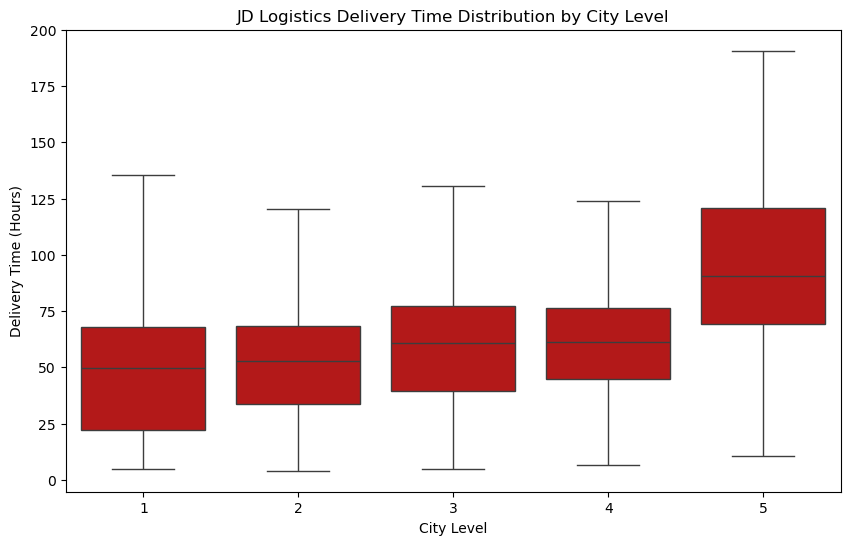

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# 只保留JD物流订单
jd_data = merged_data[merged_data['is_jd_logistics'] == True]
filtered_df = jd_data[jd_data['city_level'] != -1]

# 按城市等级分组统计
city_stats = filtered_df.groupby('city_level').agg(
    order_count=('total_delivery_time', 'count'),
    mean_time=('total_delivery_time', 'mean'),
    median_time=('total_delivery_time', 'median'),
    on_time_rate=('is_on_time', 'mean')
).reset_index()

# 打印统计结果
print(city_stats)

# 可视化：不同城市等级的配送时长分布
plt.figure(figsize=(10, 6))
sns.boxplot(x='city_level', y='total_delivery_time', data=filtered_df, palette=['#cc0000', '#cc0000', '#cc0000', '#cc0000'],showfliers=False)
plt.title('JD Logistics Delivery Time Distribution by City Level')
plt.xlabel('City Level')
plt.ylabel('Delivery Time (Hours)')
plt.show()